In [1]:
'''
2D Advection-Diffusion Equation with Zero Neumann Condition
achieved by Discretize
'''

# Import the necessary packages for the tutorial.
from discretize import TensorMesh
from pymatsolver import SolverLU
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from discretize.utils import sdiag, mkvc
mpl.rcParams.update({'font.size':14})
# sphinx_gallery_thumbnail_number = 2

In [2]:
# Construct a mesh.
h = np.ones(75)
mesh = TensorMesh([h, h], "CC")

/opt/anaconda3/envs/fluid/lib/python3.10/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


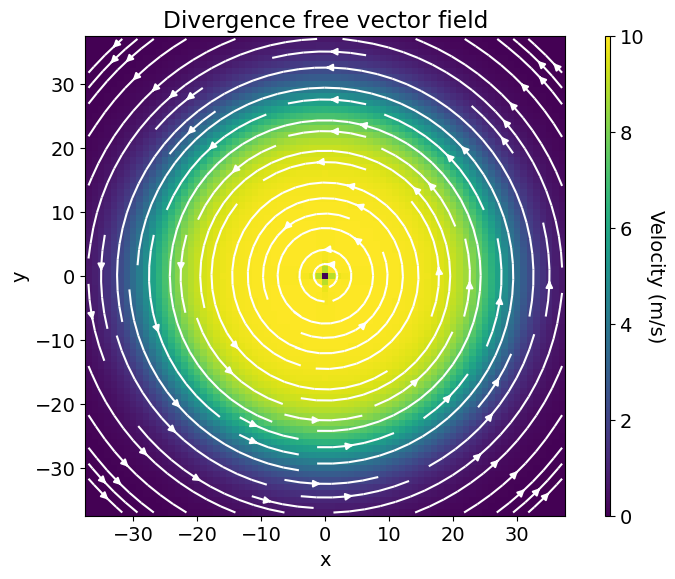

In [3]:
# Define a divergence free vector field on the faces and plot.
faces_x = mesh.faces_x
faces_y = mesh.faces_y

r_x = np.sqrt(np.sum(faces_x ** 2, axis=1))
r_y = np.sqrt(np.sum(faces_y ** 2, axis=1))

ux = 0.5 * (-faces_x[:, 1] / r_x) * (1 + np.tanh(0.15 * (28.0 - r_x)))
uy = 0.5 * (faces_y[:, 0] / r_y) * (1 + np.tanh(0.15 * (28.0 - r_y)))

u_max = 10.0                # Maximum velocity is 10 m/s
u = u_max * np.r_[ux, uy]

fig = plt.figure(figsize=(8, 6))
ax = 2 * [None]

ax[0] = fig.add_axes([0.15, 0.1, 0.6, 0.8])
mesh.plotImage(
    u,
    ax=ax[0],
    v_type="F",
    view="vec",
    stream_opts={"color": "w", "density": 1.0},
    clim=[0.0, 10.0],
)
ax[0].set_title("Divergence free vector field")

ax[1] = fig.add_axes([0.8, 0.1, 0.05, 0.8])
ax[1].set_aspect(10, anchor="W")
norm = mpl.colors.Normalize(vmin=0, vmax=u_max)
cbar = mpl.colorbar.ColorbarBase(ax[1], norm=norm, orientation="vertical")
cbar.set_label("Velocity (m/s)", rotation=270, labelpad=15)

In [4]:
# Construct the source term. Her we define a discrete vector q where qi=1 at the nearest cell center and zero for all other cells.
xycc = mesh.cell_centers
k = (xycc[:, 0] == 0) & (xycc[:, 1] == -15)  # source at (0, -15)
q = np.zeros(mesh.nC)
q[k] = 1

In [5]:
# Define the diffusivity for all cells. In this case the diffusivity is the same for all cells. 
# However, a more complex distribution of diffusivities could be created here.
a = mkvc(8.0 * np.ones(mesh.nC))

In [6]:
# Define any discrete operators and inner product matrices require to solve the problem.
Afc = mesh.average_face_to_cell                        # average face to cell matrix
Mf_inv = mesh.getFaceInnerProduct(invert_matrix=True)  # inverse of inner product matrix at faces
Mc = sdiag(mesh.vol)                                   # inner product matrix at centers
Mc_inv = sdiag(1 / mesh.vol)                           # inverse of inner product matrix at centers
Mf_alpha_inv = mesh.getFaceInnerProduct(
    a, invert_model=True, invert_matrix=True
)                       # Inverse of the inner product matrix for the reciprocal of the diffusivity

D = mesh.face_divergence                           # divergence operator

mesh.set_cell_gradient_BC(["neumann", "neumann"])  # Set zero Neumann BC
G = mesh.cell_gradient                             # modified gradient operator with BC implemented

/opt/anaconda3/envs/fluid/lib/python3.10/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.getFaceInnerProduct has been deprecated, please use TensorMesh.get_face_inner_product. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/opt/anaconda3/envs/fluid/lib/python3.10/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vol has been deprecated, please use TensorMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [7]:
# Construct the linear system that is solved at each time step.
M = -D * Mf_alpha_inv * G * Mc + mesh.dim * Afc * sdiag(u) * Mf_inv * G * Mc

dt = 0.02                          # Step width
p = np.zeros(mesh.nC)              # Initial conditions p(t=0)=0

I = sdiag(np.ones(mesh.nC))        # Identity matrix
B = I + dt * M                     # Linear system solved at each time step
s = Mc_inv * q                     # RHS

Binv = SolverLU(B)                 # Define inverse of B using solver

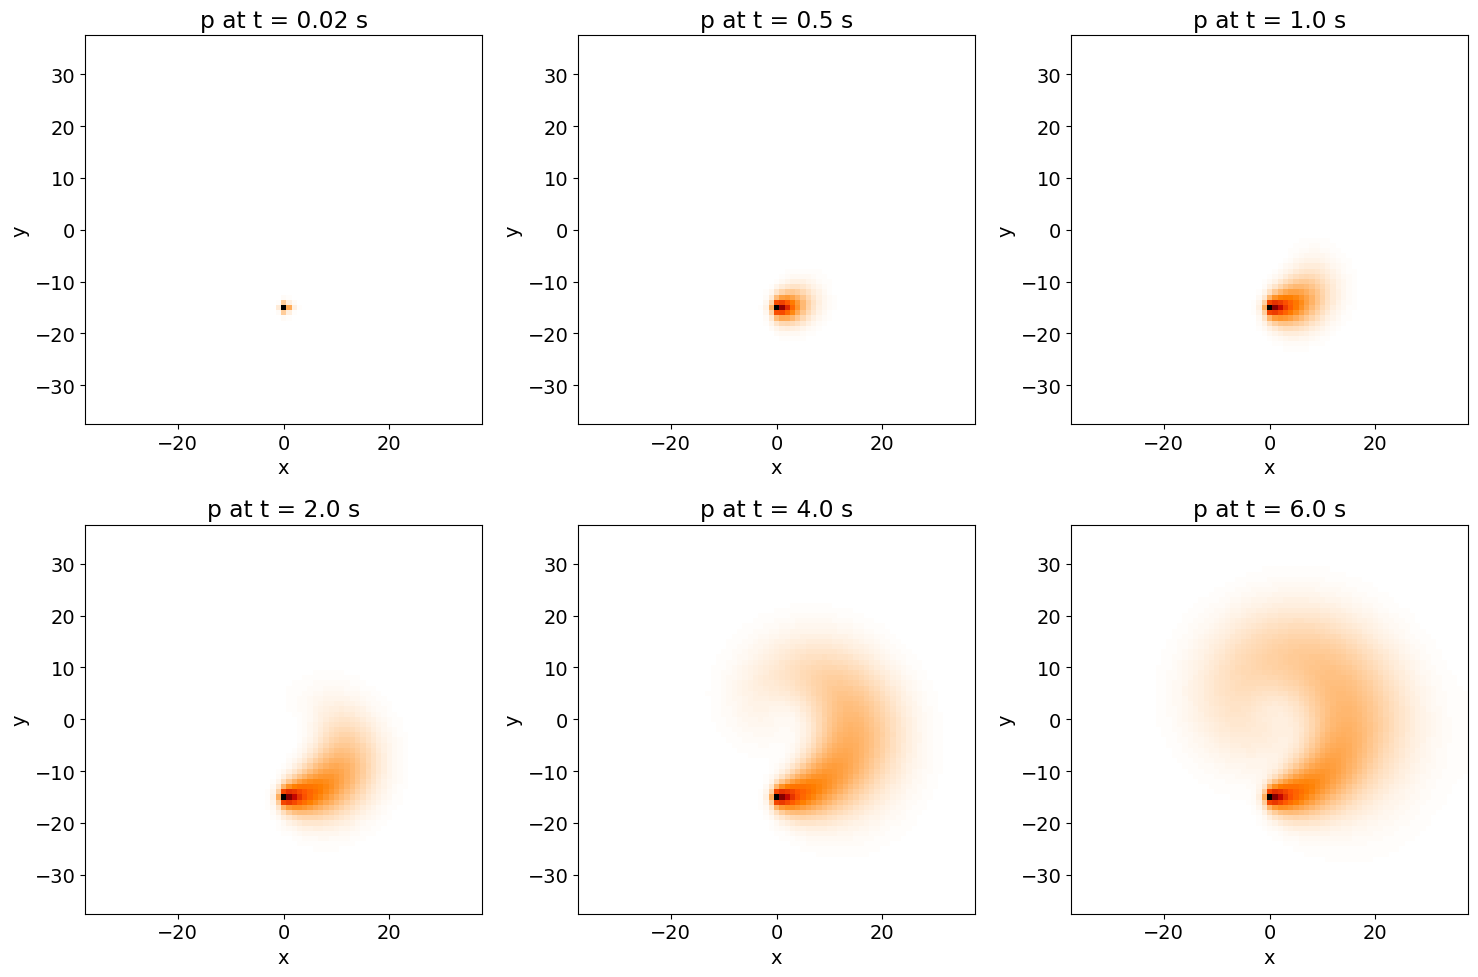

In [8]:
# Perform backward Euler at each time step and plot at specified times.
fig = plt.figure(figsize=(15, 10))
ax = 6 * [None]
n = 0

for ii in range(300):

    p = Binv * (p + s)

    if ii + 1 in (1, 25, 50, 100, 200, 300):
        ax[n] = fig.add_subplot(2, 3, n+1)
        mesh.plotImage(p, v_type="CC", ax=ax[n], pcolor_opts={"cmap": "gist_heat_r"})
        title_str = "p at t = " + str((ii + 1) * dt) + " s"
        ax[n].set_title(title_str)
        n = n + 1

plt.tight_layout()